# Household-Energy ABM: Notebook Tutorial


<span id="doc-what"></span>

**What this notebook demonstrates**  
This tutorial shows how to run our climate-linked, geospatial household‑energy ABM on a small geographic subset (ward/LSOA) *inside Jupyter*, generate hourly/daily/annual outputs and visuals, and compare ABM totals to DESNZ (electricity + gas) at LSOA level. The same core model underpins the headless CLI and the Solara dashboard.



## Inputs & prerequisites
<span id="doc-inputs"></span>

**Data you need locally**
- **Neighbourhood GeoJSON** of dwellings with at least: `UPRN` (or `fid`/`id`), `property_type`, and geometry.
- **Hourly climate parquet** with columns: `timestamp` (UTC), `latitude`, `longitude`, `temp_C` (rectangular T×P grid).
- **DESNZ LSOA workbooks** (electricity + gas, 2010–2023) for validation.

**Repository layout (high‑level):**

```
household_energy/            # Python package (entry points)
├── agent.py                 # HouseholdAgent & PersonAgent
├── model.py                 # EnergyModel core
├── climate.py               # ClimateField helpers
├── run.py                   # Headless run (CLI)
├── analyze.py               # Post‑run plots & maps
└── server.py                # Live dashboard

notebooks/
├── 01-climate-prep.ipynb    # Prepare hourly climate parquet
└── 02-energy-model-tests.ipynb  # Validation vs DESNZ (2020–2023)

data/                        # 🔒 Git‑ignored sensitive inputs
results/                     # Model outputs (git‑ignored)
```


**System requirements**

* **Python:** 3.10 or newer.
* **OS:** Linux/macOS/Windows.
* **RAM:** 8–16 GB recommended for neighbourhood‑scale runs; increase for city‑wide.
* **Disk:** Allow several GB for multi‑year hourly outputs.

---

**Installation**

Create an isolated environment and install dependencies:

```bash
python -m venv esa_mesa
source esa_mesa/bin/activate   # Windows: esa_mesa\Scripts\activate
pip install -r requirements.txt
pip install -e .
```

Once the installation is completed in the command line you can experiment with the different tools below. 

In [1]:
import sys, os, importlib, pathlib, json, subprocess, shlex
from datetime import datetime
print(sys.version)
try:
    import household_energy
    print("household_energy package is importable ✅")
except Exception as e:
    print("household_energy not importable yet. If needed, run:")
    print("!pip install -e .")
    raise


3.12.1 (v3.12.1:2305ca5144, Dec  7 2023, 17:23:38) [Clang 13.0.0 (clang-1300.0.29.30)]
household_energy package is importable ✅


## Model summary
<span id="doc-model"></span>

Each **HouseholdAgent** starts from a cached **hourly base load** (derived from calibrated annual kWh and scaled by property type, SAP, floor area, envelope, heating/fuel, and simple policy levers). **PersonAgents** add occupancy‑dependent spikes. Each hour the model samples the nearest climate grid point per dwelling; **heating/cooling** add kWh via linear degree‑based slopes around setpoints, damped when nobody is home. Model‑level reporters include `total_energy`, per‑type splits, wealth splits, and `ambient_mean_tempC`.


## Key objects & expected columns
<span id="doc-objects"></span>

Set up the path to our data and generate a few visualizations to confirm their shape and coverage. 

In [2]:
from pathlib import Path

#  --- data paths ---
GEOJSON = Path('../data/epc_abm_sunderland.geojson')
CLIMATE = Path('../data/ncc_2t_timeseries_2010_2039.parquet')
OUTDIR_QUICK = Path('results_quick')
OUTDIR_WIN   = Path('results_2020_2024')

for p in [GEOJSON, CLIMATE]:
    print(p, "exists:", p.exists())


../data/epc_abm_sunderland.geojson exists: True
../data/ncc_2t_timeseries_2010_2039.parquet exists: True


**Climate parquet schema**  
`timestamp` (UTC), `latitude`, `longitude`, `temp_C`; recommended **rectangular T×P** grid.

[Climate parquet check]
  File: ../data/ncc_2t_timeseries_2010_2039.parquet
  Rows: 3,506,400 | T: 175,320 | P: 20 | T×P: 3,506,400
  Duplicates dropped: 9120
  Rows per timestamp → min/median/max: 20/20/20
  ✅ Rectangular grid (full T×P).


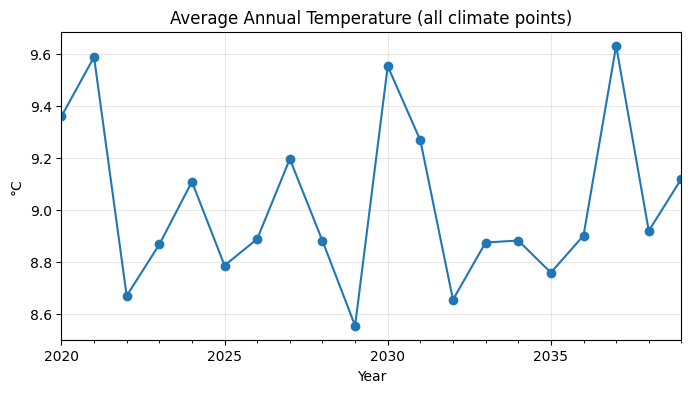

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
from household_energy.climate import ClimateField

# --- 1. Load and validate ---
ClimateField.validate_parquet(CLIMATE, verbose=True)

cf = ClimateField(CLIMATE)

# --- 2. Build dataframe: average across all points ---
temps_mean = cf.temps.mean(axis=1)  # average across P points
df = pd.DataFrame({
    "time": pd.to_datetime(cf.times),
    "temp_C": temps_mean,
}).set_index("time")

# --- 3. Resample to annual averages ---
annual = df["temp_C"].resample("YE").mean()

# --- 4. Plot ---
plt.figure(figsize=(8,4))
annual.plot(marker="o")
plt.title("Average Annual Temperature (all climate points)")
plt.ylabel("°C")
plt.xlabel("Year")
plt.grid(True, alpha=0.3)
plt.show()


The above plot shows the average annual temperature for our Newcastle polygon across the ClimateDT projections. 

Next, we'll look at our geographic coverage of these points above our polygon of interest. 

In [4]:
import pandas as pd
from household_energy.climate import ClimateField
import plotly.express as px
# --- load and slice one summer day ---

times = pd.to_datetime(cf.times)
day = "2022-07-15"  # 🔧 pick your summer day
mask = (times >= pd.to_datetime(day)) & (times < pd.to_datetime(day) + pd.Timedelta(days=1))

# take daily mean temp per point
daily_mean = cf.temps[mask, :].mean(axis=0)

# build dataframe for plotly
df = pd.DataFrame({
    "latitude": cf.points[:,0],
    "longitude": cf.points[:,1],
    "temp_C": daily_mean
})

# --- interactive scatter map ---
fig = px.scatter_map(
    df,
    lat="latitude",
    lon="longitude",
    color="temp_C",
    color_continuous_scale="RdYlBu_r",
    opacity=0.8,
    zoom=10,
    height=600,
    map_style="carto-positron",  # Maplibre basemap
    title=f"Newcastle 2m Temperature — {day}",
    labels={"temp_C": "2m Temp (°C)"}
)
fig.update_layout(margin={"r": 0, "t": 40, "l": 0, "b": 0})
fig.show()


Now we use the `household_energy.climat` module to map each home to a climate data point. The `map_households` function generates a spatial grid of climate points and then matches each household to the nearest point then assigns that temperature for that particular time period. 

Below is a visualization of how the coverage of temperature across homes varies. 

In [5]:
import numpy as np
import pandas as pd
import geopandas as gpd
import plotly.express as px
from household_energy.climate import ClimateField  # uses map_households:contentReference[oaicite:0]{index=0}

DAY = "2022-07-15"  # UTC


# 1) Climate daily mean temps
cf = ClimateField(CLIMATE)
times = pd.to_datetime(cf.times)
mask = (times >= pd.to_datetime(DAY)) & (times < pd.to_datetime(DAY) + pd.Timedelta(days=1))
daily_mean = cf.temps[mask, :].mean(axis=0)

# 2) Households lat/lon
gdf = gpd.read_file(GEOJSON).to_crs(4326)
geom = gdf.geometry
pts = geom.centroid if (geom.geom_type != "Point").any() else geom
lats, lons = pts.y.to_numpy(), pts.x.to_numpy()

# 3) Map households to climate grid
idx = cf.map_households(lats, lons)
temps_matched = daily_mean[idx]

df_hh = pd.DataFrame({"lat": lats, "lon": lons, "temp_C": temps_matched})

# 4) Plotly Maplibre scatter
fig = px.scatter_map(
    df_hh,
    lat="lat",
    lon="lon",
    color="temp_C",
    color_continuous_scale="RdYlBu_r",
    opacity=0.8,
    zoom=10,
    height=600,
    map_style="carto-positron",  # Maplibre style
    title=f"Household Coverage • Matched 2m Temp — {DAY}",
    labels={"temp_C": "2m Temp (°C)"}
)
fig.update_layout(margin={"r":0,"t":40,"l":0,"b":0})
fig.show()

In [6]:
# tidy up unused objects

import gc
gc.collect()

586

### Validate GeoJSON

In [7]:
import geopandas as gpd

# --- load households ---
gdf = gpd.read_file(GEOJSON)

# Ensure WGS84
if gdf.crs is None:
    print("⚠️ No CRS found, setting to EPSG:4326 (assumed).")
    gdf = gdf.set_crs(4326)
else:
    gdf = gdf.to_crs(4326)

# Fields used in the model
fields = [
    #"UPRN","uprn","fid",    # IDs
    "property_type","sap_rating","energy_cal_kwh","energy_demand_kwh",
    "floor_area_m2","property_age","main_fuel_type","main_heating_system",
    "retrofit_envelope_score","imd_decile",
    "heating_controls","meter_type",
    "cwi_flag","swi_flag","loft_ins_flag","floor_ins_flag","glazing_flag",
    "is_electric_heating","is_gas","is_oil","is_solid_fuel","is_off_gas"
]

present = [c for c in fields if c in gdf.columns]
missing = [c for c in fields if c not in gdf.columns]
print("✅ Found columns:", present)
print("❌ Missing columns:", missing)

# Descriptive stats
desc = {}
for c in present:
    if gdf[c].dtype.kind in "biufc":  # numeric
        desc[c] = gdf[c].describe().to_dict()
    else:  # categorical
        desc[c] = gdf[c].value_counts(dropna=False).head(10).to_dict()

import json
print(json.dumps(desc, indent=2))


✅ Found columns: ['property_type', 'sap_rating', 'energy_cal_kwh', 'energy_demand_kwh', 'floor_area_m2', 'property_age', 'main_fuel_type', 'main_heating_system', 'retrofit_envelope_score', 'heating_controls', 'meter_type', 'cwi_flag', 'swi_flag', 'loft_ins_flag', 'floor_ins_flag', 'glazing_flag', 'is_electric_heating', 'is_gas', 'is_oil', 'is_solid_fuel', 'is_off_gas']
❌ Missing columns: ['imd_decile']
{
  "property_type": {
    "semi-detached house": 58818,
    "mid-terraced house": 41565,
    "small block of flats/dwelling converted in to flats": 24478,
    "end-terraced house": 18334,
    "detached house": 13209,
    "large block of flats": 8014,
    "block of flats": 33
  },
  "sap_rating": {
    "count": 164451.0,
    "mean": 66.20314257742427,
    "std": 11.43086203959144,
    "min": 1.0,
    "25%": 60.0,
    "50%": 68.0,
    "75%": 73.0,
    "max": 123.0
  },
  "energy_cal_kwh": {
    "count": 164451.0,
    "mean": 10980.547272280279,
    "std": 7833.689038765528,
    "min": -14

Next we'll plot a sample of the data over the Newcastle area so we can visually inspect the components. 

In [8]:
import numpy as np
import pandas as pd
import geopandas as gpd
import folium
from folium.plugins import MarkerCluster
import branca.colormap as cm

# --- load & prep ---
gpts = gdf.dropna(subset=["geometry"]).copy()
gpts = gpts.to_crs(4326) if gpts.crs else gpts.set_crs(4326)
if (gpts.geometry.geom_type != "Point").any():
    gpts["geometry"] = gpts.geometry.centroid

# Color scale from calibrated kWh (p5–p95 caps)
ene = pd.to_numeric(gpts["energy_cal_kwh"], errors="coerce")
if np.isfinite(ene).any():
    vmin, vmax = np.nanpercentile(ene, [5, 95])
else:
    vmin, vmax = 0.0, 1.0
cmap = cm.linear.YlOrRd_09.scale(vmin, vmax).to_step(10)
cmap.caption = "Calibrated annual energy (kWh)"

def color_for(val):
    if pd.isna(val):
        return "#bdbdbd"
    return cmap(min(max(float(val), vmin), vmax))

# Map scaffold
centre = [gpts.geometry.y.mean(), gpts.geometry.x.mean()]
m = folium.Map(location=centre, zoom_start=12, tiles="CartoDB positron")

title_html = """
<div style="position: fixed; top: 10px; left: 50px; z-index: 9999;
     background: rgba(255,255,255,.9); padding: 6px 10px; border-radius: 6px;
     font-family: system-ui, -apple-system, Segoe UI, Roboto, sans-serif; font-size: 14px;">
  <b>Household Energy — Calibrated kWh/year</b>
</div>"""
m.get_root().html.add_child(folium.Element(title_html))

# --- (A) Pseudo-heatmap: many small, translucent dots  ---
MAX_ALL = 60000  # adjust based on browser perf 
base = gpts if len(gpts) <= MAX_ALL else gpts.sample(MAX_ALL, random_state=0)
layer_all = folium.FeatureGroup(name=f"All households (n={len(base):,})", show=True)
for r in base.itertuples():
    val = getattr(r, "energy_cal_kwh", np.nan)
    col = color_for(val)
    folium.CircleMarker(
        location=[r.geometry.y, r.geometry.x],
        radius=2,                # tiny dot
        color=col, weight=0,     # no stroke
        fill=True, fill_color=col, fill_opacity=0.35,  # translucent
    ).add_to(layer_all)
layer_all.add_to(m)

# --- (B) Sampled popups layer (storytelling) ---
SAMPLE_N = min(len(gpts), 5000)  # tweak as you like
sample = gpts.sample(SAMPLE_N, random_state=42)
cluster = MarkerCluster(name=f"Sampled homes (n={len(sample):,})", show=False).add_to(m)

def fmt(x, d=0):
    try:
        return f"{float(x):,.{d}f}"
    except Exception:
        return "—"

for r in sample.itertuples():
    val = getattr(r, "energy_cal_kwh", np.nan)
    col = color_for(val)
    popup = folium.Popup(f"""
        <div style="font-family:system-ui, sans-serif; font-size:12px; line-height:1.25;">
          <b>UPRN:</b> {getattr(r,'UPRN','—')}<br/>
          <b>Type:</b> {getattr(r,'property_type','—')} | <b>Age:</b> {getattr(r,'property_age','—')}<br/>
          <b>Fuel:</b> {getattr(r,'main_fuel_type','—')} | <b>System:</b> {getattr(r,'main_heating_system','—')}<br/>
          <b>Energy:</b> {fmt(val,0)} kWh/yr
        </div>
    """, max_width=320)
    folium.CircleMarker(
        location=[r.geometry.y, r.geometry.x],
        radius=3, color=col, weight=0.5, opacity=0.9,
        fill=True, fill_color=col, fill_opacity=0.85,
        popup=popup,
        tooltip=f"{fmt(val,0)} kWh/yr" if pd.notna(val) else None,
    ).add_to(cluster)

# Legend + layers
cmap.add_to(m)

# --- (C) Add annual temperature layer ---
YEAR = 2022                   

cf = ClimateField(CLIMATE)
times = pd.to_datetime(cf.times, utc=True)

# slice calendar year in UTC
start = pd.Timestamp(f"{YEAR}-01-01", tz="UTC")
end   = pd.Timestamp(f"{YEAR+1}-01-01", tz="UTC")
mask  = (times >= start) & (times < end)
assert mask.any(), f"No climate rows in {YEAR}. Range: {times.min()} → {times.max()}"

# Annual mean temperature per climate point (shape [P])
ann_meanP = cf.temps[mask, :].mean(axis=0)

# Map ONLY the sampled households to nearest climate point
s_lats = sample.geometry.y.to_numpy(np.float32)
s_lons = sample.geometry.x.to_numpy(np.float32)
s_idx  = cf.map_households(s_lats, s_lons)
s_temp = ann_meanP[s_idx]  # per-sampled-household annual mean °C

# Temp color scale from the sample distribution
tmin, tmax = (np.nanpercentile(s_temp, [5, 95])
              if np.isfinite(s_temp).any() else (0.0, 1.0))
tmap = cm.LinearColormap(
    colors=list(reversed(cm.linear.RdYlBu_11.colors)),
    vmin=float(tmin),
    vmax=float(tmax),
)
tmap.caption = f"Annual mean 2m temp (°C) • {YEAR}"

# Render: small, translucent dots (same look), optional pane so temp sits under energy
layer_hh = folium.FeatureGroup(name=f"Sampled • annual mean temp {YEAR} (n={len(sample):,})", show=False)
for (y, x, t) in zip(s_lats, s_lons, s_temp):
    if not np.isfinite(t):
        continue
    col = tmap(min(max(float(t), tmin), tmax))
    folium.CircleMarker(
        [y, x],
        radius=2,
        color=col, weight=0,
        fill=True, fill_color=col, fill_opacity=0.22,  # extra translucent so energy still pops
        tooltip=f"{t:.2f} °C",
    ).add_to(layer_hh)
layer_hh.add_to(m)

tmap.add_to(m)
 
folium.LayerControl(collapsed=False).add_to(m)



In [9]:
from IPython.display import IFrame

m.save("household_energy_map.html")


In [10]:
out = Path("household_energy_map.html").resolve()
print("Open in browser:", out.as_uri())


Open in browser: file:///Users/abeltran/Documents/GitHub/spdt_abm/notebooks/household_energy_map.html


**EnergyModel(...)**  
- Required: `gdf` (GeoDataFrame of dwellings). Optional: `climate_parquet`, `climate_start` (UTC), `local_tz`, `collect_agent_level`, `agent_collect_every`.

In [11]:
from household_energy.model import EnergyModel
from household_energy.climate import ClimateField
import pandas as pd
import geopandas as gpd
gdf = gpd.read_file(GEOJSON)

Below we print a list of Wards for us to select from.

In [12]:
# Inspect columns first to confirm the right field
print(gdf.columns)

# Then list unique ward names
wards = gdf["ward_code"].dropna().unique()
print(f"Found {len(wards)} wards:")
for w in sorted(wards):
    print(" •", w)


Index(['UPRN', 'lsoa_code', 'local_authority', 'ward_code', 'habitable_rooms',
       'sap_rating', 'floor_area_m2', 'property_type', 'property_age',
       'main_fuel_type', 'main_heating_system', 'sap_band_ord',
       'retrofit_envelope_score', 'is_off_gas', 'energy_demand_kwh', 'factor',
       'energy_cal_kwh', 'heating_controls', 'meter_type', 'cwi_flag',
       'swi_flag', 'loft_ins_flag', 'floor_ins_flag', 'glazing_flag',
       'is_electric_heating', 'is_gas', 'is_oil', 'is_solid_fuel',
       'epc_lodgement_date_year', 'geometry'],
      dtype='object')
Found 38 wards:
 • E05001067
 • E05001078
 • E05001084
 • E05001087
 • E05001138
 • E05001139
 • E05001141
 • E05001151
 • E05001153
 • E05001154
 • E05001155
 • E05001156
 • E05001157
 • E05001158
 • E05001159
 • E05001160
 • E05001161
 • E05001162
 • E05001163
 • E05001164
 • E05001165
 • E05001166
 • E05001167
 • E05001168
 • E05001169
 • E05001170
 • E05001171
 • E05001172
 • E05001173
 • E05001174
 • E05001175
 • E0500117

In [13]:
ward_name = wards[2] # 🔧 pick your ward by name/code
gdf_small = gdf[gdf["ward_code"] == ward_name].copy()
print(f"{len(gdf_small)} dwellings in {ward_name}")

7308 dwellings in E05001168


In [14]:
clim_path = CLIMATE  
cf = ClimateField(clim_path)
start_utc = pd.to_datetime(cf.times[0], utc=True)  # begin at climate start
print(start_utc)

m = EnergyModel(
    gdf=gdf_small,
    climate_parquet=clim_path,
    climate_start=start_utc,
    local_tz="Europe/London",
    collect_agent_level=True,   # keep per-household traces
    agent_collect_every=24      # once per day
)


2020-01-01 00:00:00+00:00


/Users/abeltran/Documents/GitHub/spdt_abm/household_energy/model.py:191: RuntimeWarning:

Mean of empty slice



In [15]:
for h in range(24*7):   # e.g. 3 days
    m.step()

df_model = m.model_dc.get_model_vars_dataframe()
df_agent = m.agent_dc.get_agent_vars_dataframe()

print(df_model.head())
print(df_agent.head())


   mid-terraced house  semi-detached house  \
0            0.000000             0.000000   
1        14924.702428          7809.627682   
2        14830.485130          7765.458730   
3        14769.123778          7736.692605   
4        14705.712352          7706.965407   

   small block of flats/dwelling converted in to flats  large block of flats  \
0                                           0.000000                0.000000   
1                                        9271.857745             3578.224412   
2                                        9200.717071             3550.701496   
3                                        9154.384942             3532.776514   
4                                        9106.504864             3514.252662   

   block of flats  end-terraced house  detached house  \
0        0.000000            0.000000        0.000000   
1        4.737019         4291.787888      999.970056   
2        4.700273         4264.228226      996.074957   
3        4.676

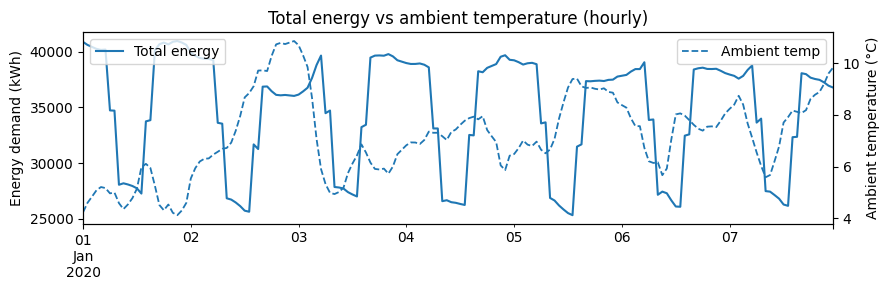

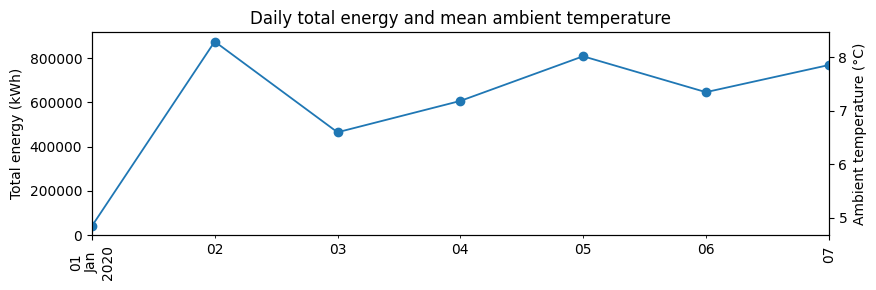

/var/folders/rz/68rzz4790djdsk13ycd911f00000gr/T/ipykernel_78357/2338206416.py:98: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.



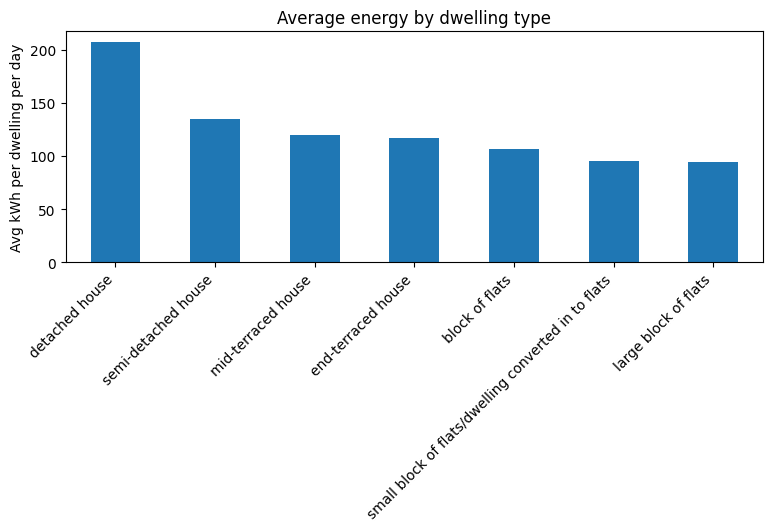

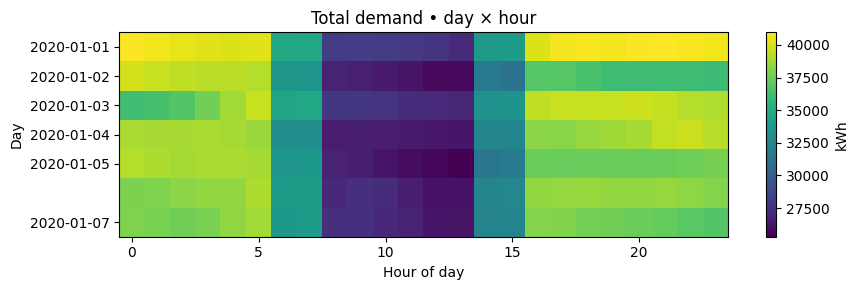

In [16]:
# ===== Demo visuals: hourly + daily + by-type + day×hour =====
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# --- helpers ---------------------------------------------------
def model_df_with_time(m):
    """Return model-level df with a proper UTC hourly DateTimeIndex, t=0 dropped."""
    df = m.datacollector.get_model_vars_dataframe().copy()
    # Drop the initialization snapshot (before first step)
    df = df.iloc[1:].copy()
    if getattr(m, "climate", None) is not None:
        start_utc = pd.to_datetime(m.climate.times[getattr(m, "_t0", 0)], utc=True)
        df.index = start_utc + pd.to_timedelta(np.arange(len(df)), unit="h")
        df.index.name = "hour_start_utc"
    return df

def agent_household_df(m):
    """Flatten agent-level df and keep only households (if collected)."""
    if getattr(m, "agent_dc", None) is None:
        return None
    try:
        df = m.agent_dc.get_agent_vars_dataframe()
    except Exception:
        return None
    if isinstance(df.index, pd.MultiIndex):
        df = df.reset_index()
    if "agent_type" in df.columns:
        df = df[df["agent_type"] == "household"].copy()
    return df

# --- pull data -------------------------------------------------
model_df = model_df_with_time(m)
agent_df = agent_household_df(m)

# 1) Hourly: Total energy vs ambient temperature ----------------
fig, ax1 = plt.subplots(figsize=(9,3))
model_df["total_energy"].plot(ax=ax1, label="Total energy", lw=1.5)
ax1.set_ylabel("Energy demand (kWh)")
ax1.set_xlabel("")
ax1.set_title("Total energy vs ambient temperature (hourly)")
ax2 = ax1.twinx()
if "ambient_mean_tempC" in model_df.columns:
    model_df["ambient_mean_tempC"].plot(ax=ax2, linestyle="--", lw=1.3, label="Ambient temp")
    ax2.set_ylabel("Ambient temperature (°C)")
    # Light legends
    ax1.legend(loc="upper left")
    ax2.legend(loc="upper right")
fig.tight_layout()
plt.show()

# 2) Daily aggregates: bar (kWh) + temp overlay -----------------
daily = model_df.resample("D").agg({
    "total_energy": "sum",
    **({"ambient_mean_tempC": "mean"} if "ambient_mean_tempC" in model_df.columns else {})
})
fig, ax = plt.subplots(figsize=(9,3))
daily["total_energy"].plot(kind="bar", ax=ax)
ax.set_ylabel("Total energy (kWh)")
ax.set_xlabel("")
ax.set_title("Daily total energy and mean ambient temperature")
if "ambient_mean_tempC" in daily.columns:
    ax2 = ax.twinx()
    daily["ambient_mean_tempC"].plot(ax=ax2, marker="o", lw=1.3)
    ax2.set_ylabel("Ambient temperature (°C)")
fig.tight_layout()
plt.show()

# 3) By dwelling type: period totals (uses model's energy_by_type keys) ---
prop_cols = [c for c in model_df.columns if hasattr(m, "energy_by_type") and c in m.energy_by_type.keys()]

if prop_cols:
    # Period totals by type (kWh over the simulated window)
    totals_by_type = model_df[prop_cols].sum()

    # How many dwellings of each type were actually simulated (in this ward subset)
    type_counts = Counter((getattr(h, "property_type", "") or "").strip().lower() for h in m.household_agents)
    counts = pd.Series({k: type_counts.get(k, 0) for k in totals_by_type.index})

    # Keep only types with at least one dwelling
    valid = counts > 0
    totals_by_type = totals_by_type[valid]
    counts = counts[valid]

    # Convert to average kWh per dwelling per day
    hours = float(len(model_df))
    days = max(1.0, hours / 24.0)
    avg_per_dwelling_per_day = (totals_by_type / counts) / days

    # Plot
    fig, ax = plt.subplots(figsize=(9,3))
    avg_per_dwelling_per_day.sort_values(ascending=False).plot(kind="bar", ax=ax)
    ax.set_ylabel("Avg kWh per dwelling per day")
    ax.set_title("Average energy by dwelling type")
    ax.set_xlabel("")
    plt.xticks(rotation=45, ha="right")
    fig.tight_layout()
    plt.show()
else:
    print("ℹ️ No property-type columns found in model_df; skipping by-type chart.")
# 4) Day × Hour heatmap (hourly demand structure) ---------------
# Require a DateTimeIndex so .index.hour/.index.day are well-defined
if isinstance(model_df.index, pd.DatetimeIndex):
    pivot = model_df.pivot_table(
        index=model_df.index.normalize(),            # by calendar day
        columns=model_df.index.hour,
        values="total_energy",
        aggfunc="sum",
    )
    fig = plt.figure(figsize=(9,3))
    im = plt.imshow(pivot.values, aspect="auto")
    plt.colorbar(im, label="kWh")
    plt.xlabel("Hour of day")
    plt.ylabel("Day")
    plt.title("Total demand • day × hour")
    # Tidy y-ticks to show dates sparsely
    yticks = np.linspace(0, len(pivot.index)-1, min(len(pivot.index), 6)).astype(int)
    plt.yticks(yticks, [d.strftime("%Y-%m-%d") for d in pivot.index[yticks]])
    fig.tight_layout()
    plt.show()
else:
    print("ℹ️ model_df does not have a DateTimeIndex; skipping day×hour heatmap.")


Next, we'll run the model for the largest LSOA in Newcastle.

In [17]:
# ---- Find LSOA column & pick largest by dwelling count ----
import re
import pandas as pd

# 1) auto-detect an LSOA-like column
def find_lsoa_col(df):
    cands = [c for c in df.columns if re.search(r"lsoa", str(c), flags=re.I)]
    if cands:
        # prefer more specific names if multiple
        for pref in ["lsoa_name", "lsoa11nm", "lsoa_code", "lsoa11cd"]:
            for c in cands:
                if c.lower() == pref.lower():
                    return c
        return cands[0]
    raise KeyError("No LSOA-like column found (looked for names containing 'lsoa').")

lsoa_col = find_lsoa_col(gdf)
counts = gdf[lsoa_col].value_counts(dropna=True)
top_lsoa = counts.index[0]
n_homes = int(counts.iloc[0])
print(f"Top LSOA by dwelling count: {top_lsoa} ({n_homes:,} homes) [column: {lsoa_col}]")

# 2) filter to that LSOA
gdf_lsoa = gdf[gdf[lsoa_col] == top_lsoa].copy()
print(f"Subset size: {len(gdf_lsoa):,} rows")


Top LSOA by dwelling count: E01008703 (3,428 homes) [column: lsoa_code]
Subset size: 3,428 rows


In [ ]:
from household_energy.model import EnergyModel
from household_energy.climate import ClimateField
import pandas as pd
import numpy as np

# paths & window
clim_path   = CLIMATE   # <-- your prepared hourly parquet
start_utc_i = pd.Timestamp("2020-01-01T00:00:00Z")
end_utc_e   = pd.Timestamp("2025-01-01T00:00:00Z")   # exclusive

# 1) Inspect climate & compute aligned hour range (like run.py)
cf = ClimateField(clim_path)
i0 = cf.time_index_for(start_utc_i)
i1 = cf.time_index_for(end_utc_e)
if i1 <= i0:
    raise ValueError("Window invalid for this climate file (end <= start).")
T_hours = int(i1 - i0)

# Align start to the climate grid's actual timestamp at i0 (exact hour on the parquet)
start_utc_aligned = pd.to_datetime(cf.times[i0], utc=True)   # aligns to grid:contentReference[oaicite:3]{index=3}
print(f"Aligned window: {start_utc_aligned} → {start_utc_aligned + pd.to_timedelta(T_hours, 'h')} (exclusive)")
print(f"Hours to simulate: {T_hours:,}")

# 2) Build the model (agent-level off for long runs; can turn on if you need it)
m = EnergyModel(
    gdf=gdf_lsoa,
    climate_parquet=clim_path,
    climate_start=start_utc_aligned,
    local_tz="Europe/London",
    collect_agent_level=False,     # faster; set True if you need household traces
    agent_collect_every=24,
)

######
# edits to dial down energy spikes to calibration.
# — dial down occupant spikes from kWh/h to something realistic —
m.energy_per_person_home = 0.06   # ~1.44 kWh/day per person
m.energy_per_person_away = 0.01   # ~0.24 kWh/day per person

# — soften climate sensitivity —
m.heating_slope_kWh_per_deg = 0.03
m.cooling_slope_kWh_per_deg = 0.02

# — reduce the base to represent realistic away from home energy use. —
for h in m.household_agents:
    h.annual_energy_kwh *= 0.5    # adjust 0.4–0.6 until ABM≈DESNZ
    h.refresh_hourly_base()
######

# 3) Run
print_every = 24*7*52  # yearly progress
for h in range(T_hours):
    m.step()
    if (h + 1) % print_every == 0:
        print(f" progressed {h+1:,}/{T_hours:,} hours")

print("✅ Windowed run complete.")


Aligned window: 2020-01-01 00:00:00+00:00 → 2025-01-01 00:00:00+00:00 (exclusive)
Hours to simulate: 43,848


/Users/abeltran/Documents/GitHub/spdt_abm/household_energy/model.py:191: RuntimeWarning:

Mean of empty slice



In [ ]:
# Model-level DataCollector → hourly dataframe with UTC index (t=0 dropped)
model_df = m.datacollector.get_model_vars_dataframe().copy()
model_df["hour_start_utc"] = start_utc_aligned + pd.to_timedelta(model_df.index - 1, unit="h")
model_df = model_df.set_index("hour_start_utc").iloc[1:]  # drop t=0 init row

# Clamp to the requested window (redundant but explicit)
model_df = model_df.loc[(model_df.index >= start_utc_aligned) & (model_df.index < end_utc_e)]

# Quick sanity prints
print(model_df.shape, "rows (hours)")
print(model_df.columns.tolist()[:8], "…")

# Optional: daily aggregates like the CLI's model_daily.parquet
daily = pd.DataFrame({
    "total_energy_kWh":       model_df["total_energy"].resample("D").sum(),
    "ambient_mean_tempC_avg": model_df["ambient_mean_tempC"].resample("D").mean()
                              if "ambient_mean_tempC" in model_df.columns else np.nan,
})
daily.index.name = "date_utc"

daily.head()


(43848, 15) rows (hours)
['mid-terraced house', 'semi-detached house', 'small block of flats/dwelling converted in to flats', 'large block of flats', 'block of flats', 'end-terraced house', 'detached house', 'flat in mixed use building'] …


total_energy_kWh  ambient_mean_tempC_avg
date_utc                                                           
2020-01-01 00:00:00+00:00      54649.849444                4.844681
2020-01-02 00:00:00+00:00      46589.242557                8.291658
2020-01-03 00:00:00+00:00      50427.091039                6.596907
2020-01-04 00:00:00+00:00      49269.008913                7.182390
2020-01-05 00:00:00+00:00      47311.537920                8.016729

/var/folders/rz/68rzz4790djdsk13ycd911f00000gr/T/ipykernel_78089/100449034.py:33: FutureWarning:

'Y' is deprecated and will be removed in a future version, please use 'YE' instead.

/var/folders/rz/68rzz4790djdsk13ycd911f00000gr/T/ipykernel_78089/100449034.py:36: FutureWarning:

'Y' is deprecated and will be removed in a future version, please use 'YE' instead.



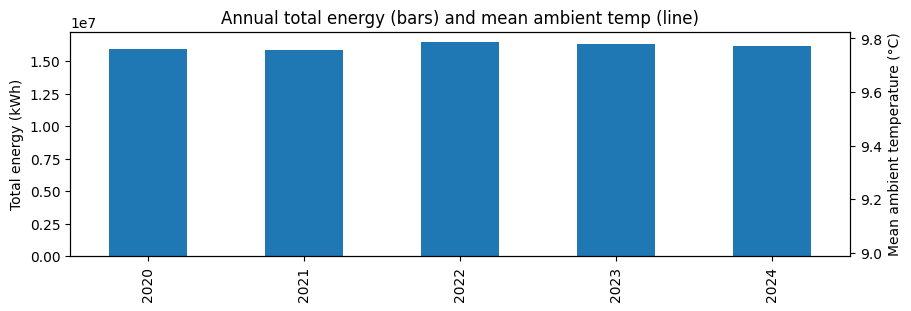

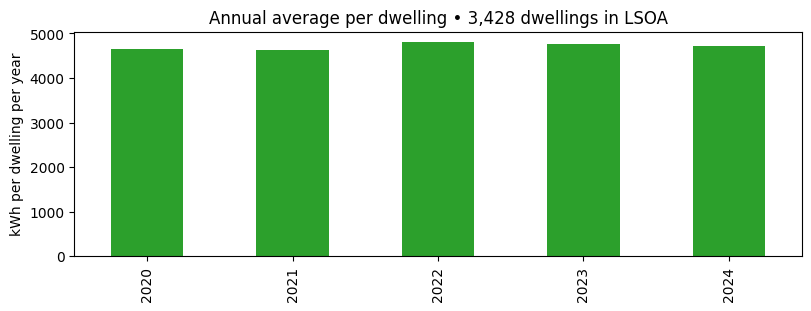

/var/folders/rz/68rzz4790djdsk13ycd911f00000gr/T/ipykernel_78089/100449034.py:66: FutureWarning:

'Y' is deprecated and will be removed in a future version, please use 'YE' instead.



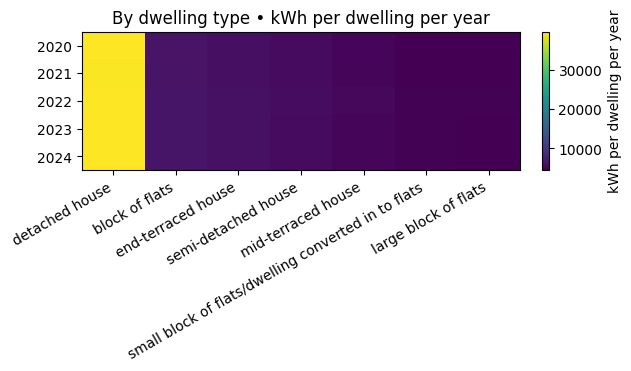

In [ ]:
# ===== Annual summaries for 2020–2024 window =====
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# --- 0) Ensure we have model_df with a UTC DateTimeIndex (drop t=0) ----
def ensure_model_df(m, start_utc_aligned=None):
    df = m.datacollector.get_model_vars_dataframe().copy()
    # If we've already set a DateTimeIndex, keep it
    if not isinstance(df.index, pd.DatetimeIndex):
        if start_utc_aligned is None:
            # fall back to model clock if needed
            start_utc_aligned = pd.to_datetime(getattr(m.climate, "times", [])[getattr(m, "_t0", 0)], utc=True)
        df["hour_start_utc"] = start_utc_aligned + pd.to_timedelta(df.index - 1, unit="h")
        df = df.set_index("hour_start_utc")
    # Drop the init snapshot
    if len(df) and df.index.is_monotonic_increasing:
        df = df.iloc[1:]
    return df

try:
    _ = model_df  # if you already created it earlier
except NameError:
    model_df = ensure_model_df(m, start_utc_aligned=start_utc_aligned)

# Clamp to your intended window if you defined end_utc_e
if 'end_utc_e' in globals() and end_utc_e is not None:
    model_df = model_df.loc[model_df.index < end_utc_e]

# --- 1) Annual totals + mean ambient temperature -----------------------
annual = pd.DataFrame({
    "total_energy_kWh": model_df["total_energy"].resample("Y").sum()
})
if "ambient_mean_tempC" in model_df.columns:
    annual["mean_tempC"] = model_df["ambient_mean_tempC"].resample("Y").mean()
annual.index = annual.index.year

fig, ax = plt.subplots(figsize=(9,3), constrained_layout=True)
annual["total_energy_kWh"].plot(kind="bar", ax=ax)
ax.set_ylabel("Total energy (kWh)")
ax.set_xlabel("")
ax.set_title("Annual total energy (bars) and mean ambient temp (line)")
if "mean_tempC" in annual.columns:
    ax2 = ax.twinx()
    annual["mean_tempC"].plot(ax=ax2, marker="o", lw=1.3)
    ax2.set_ylabel("Mean ambient temperature (°C)")
plt.show()

# --- 2) Annual average per dwelling (normalize by LSOA dwelling count) --
n_dwellings = len(gdf_lsoa)
annual["avg_kWh_per_dwelling"] = annual["total_energy_kWh"] / max(1, n_dwellings)

fig, ax = plt.subplots(figsize=(8,3), constrained_layout=True)
annual["avg_kWh_per_dwelling"].plot(kind="bar", ax=ax, color="tab:green")
ax.set_ylabel("kWh per dwelling per year")
ax.set_xlabel("")
ax.set_title(f"Annual average per dwelling • {n_dwellings:,} dwellings in LSOA")
plt.show()

# --- 3) By dwelling type: kWh per dwelling per year (heatmap) ----------
# Identify the property-type columns the model records (same keys as EnergyModel.energy_by_type)
prop_cols = [c for c in model_df.columns if hasattr(m, "energy_by_type") and c in m.energy_by_type.keys()]
if prop_cols:
    # Annual totals by type
    annual_type = model_df[prop_cols].resample("Y").sum()
    annual_type.index = annual_type.index.year

    # Count dwellings by type in THIS LSOA subset
    counts_by_type = (gdf_lsoa.get("property_type")
                      .astype(str).str.strip().str.lower()
                      .value_counts())

    # Align columns to counts and compute per-dwelling kWh/year
    # (drop types with zero homes to avoid divide-by-zero)
    keep = [c for c in annual_type.columns if counts_by_type.get(c, 0) > 0]
    annual_type = annual_type[keep]
    denom = pd.Series({c: counts_by_type[c] for c in keep})
    per_dw_per_year = annual_type.div(denom, axis=1)

    # Optional: sort columns by total average usage descending
    order = per_dw_per_year.mean(axis=0).sort_values(ascending=False).index.tolist()
    per_dw_per_year = per_dw_per_year[order]

    # Heatmap (years × property types)
    fig, ax = plt.subplots(figsize=(min(12, 2 + 0.6*len(order)), 3.6), constrained_layout=True)
    im = ax.imshow(per_dw_per_year.values, aspect="auto")
    ax.set_yticks(range(len(per_dw_per_year.index)))
    ax.set_yticklabels(per_dw_per_year.index.astype(int))
    ax.set_xticks(range(len(order)))
    ax.set_xticklabels(order, rotation=30, ha="right")
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label("kWh per dwelling per year")
    ax.set_title("By dwelling type • kWh per dwelling per year")
    plt.show()
else:
    print("ℹ️ No property-type energy columns present; skipping type heatmap.")


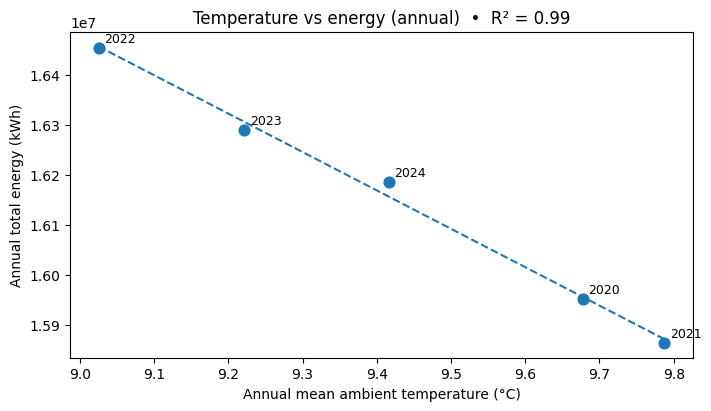

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def get_annual_from_model(model_df):
    annual_ = pd.DataFrame({
        "total_energy_kWh": model_df["total_energy"].resample("Y").sum()
    })
    if "ambient_mean_tempC" in model_df.columns:
        annual_["mean_tempC"] = model_df["ambient_mean_tempC"].resample("Y").mean()
    annual_.index = annual_.index.year
    return annual_

# (re)build annual if needed
if "annual" not in globals():
    annual = get_annual_from_model(model_df)

# Only plot if we have temperature
if "mean_tempC" in annual.columns and annual["mean_tempC"].notna().any():
    x = annual["mean_tempC"].astype(float).values
    y = annual["total_energy_kWh"].astype(float).values

    # Fit simple linear model y = a*x + b
    a, b = np.polyfit(x, y, 1)
    yhat = a * x + b
    r2 = 1 - np.sum((y - yhat)**2) / np.sum((y - y.mean())**2)

    fig, ax = plt.subplots(figsize=(7,4), constrained_layout=True)
    ax.scatter(x, y, s=60)
    xs = np.linspace(min(x), max(x), 100)
    ax.plot(xs, a*xs + b, linestyle="--")
    for yr, xi, yi in zip(annual.index, x, y):
        ax.annotate(str(yr), (xi, yi), xytext=(4,4), textcoords="offset points", fontsize=9)
    ax.set_xlabel("Annual mean ambient temperature (°C)")
    ax.set_ylabel("Annual total energy (kWh)")
    ax.set_title(f"Temperature vs energy (annual)  •  R² = {r2:.2f}")
    plt.show()
else:
    print("ℹ️ No ambient temperature in model_df; skipping temp–energy scatter.")


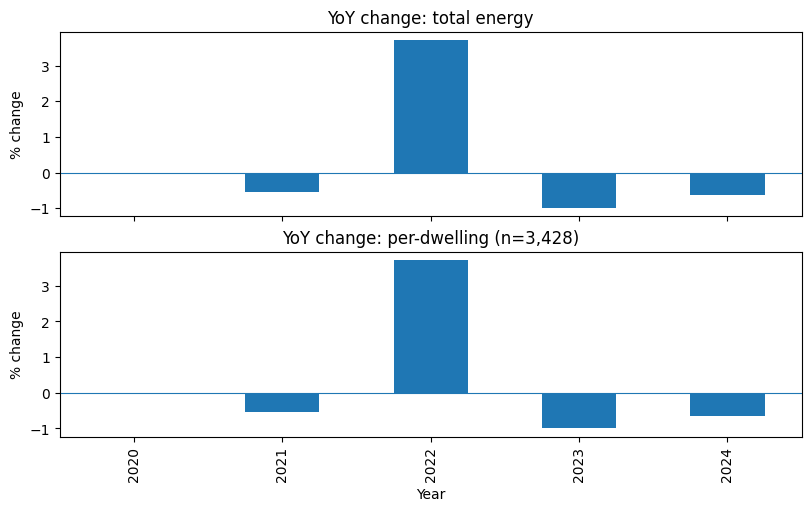

total_%Δ  per_dwelling_%Δ
hour_start_utc                           
2020                 NaN              NaN
2021                -0.5             -0.5
2022                 3.7              3.7
2023                -1.0             -1.0
2024                -0.6             -0.6

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure we have 'annual'
if "annual" not in globals():
    annual = get_annual_from_model(model_df)

n_dwellings = len(gdf_lsoa)

plot_df = pd.DataFrame({
    "total_kWh": annual["total_energy_kWh"],
    "kWh_per_dwelling": annual["total_energy_kWh"] / max(1, n_dwellings),
})
pct = plot_df.pct_change() * 100  # % change YoY

fig, axes = plt.subplots(2, 1, figsize=(8,5), constrained_layout=True, sharex=True)

pct["total_kWh"].plot(kind="bar", ax=axes[0])
axes[0].axhline(0, linewidth=0.8)
axes[0].set_ylabel("% change")
axes[0].set_title("YoY change: total energy")

pct["kWh_per_dwelling"].plot(kind="bar", ax=axes[1])
axes[1].axhline(0, linewidth=0.8)
axes[1].set_ylabel("% change")
axes[1].set_title(f"YoY change: per-dwelling (n={n_dwellings:,})")

axes[1].set_xlabel("Year")
plt.show()

# Optional: print a tidy table
display(pct.round(1).rename(columns={"total_kWh":"total_%Δ", "kWh_per_dwelling":"per_dwelling_%Δ"}))


## Validation against DESNZ (LSOA)
<span id="doc-desnz"></span>

Use the notebook’s tidy loader to normalize DESNZ LSOA sheets and combine **electricity + gas** by **LSOA × year**. Compare **ABM annual totals** (`model_df.resample("YS")`) to DESNZ **Elec+Gas** totals for **2020–2023**, scoped to the **same LSOA** you simulated. For per‑dwelling comparisons, divide totals by the number of dwellings in the subset (or by type‑specific counts).


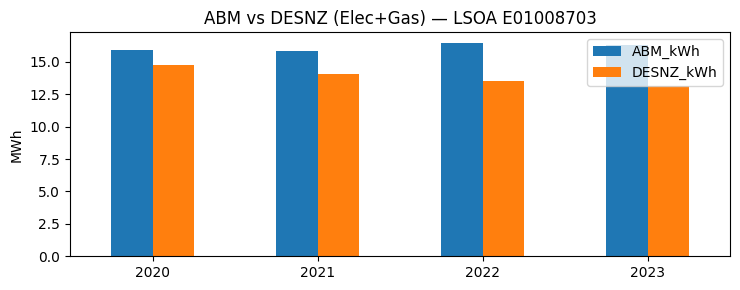

In [ ]:
# === Read DESNZ (LSOA Elec+Gas) → combine → compare to ABM for the current LSOA (2020–2023) ===
from pathlib import Path
import pandas as pd, numpy as np, re, matplotlib.pyplot as plt

# ---- Paths & config (edit if needed) ----
ELEC_XLSX = "/Users/abeltran/Library/CloudStorage/OneDrive-TheAlanTuringInstitute/dt/esa/energy/LSOA_domestic_elec_2010-2023.xlsx"
GAS_XLSX  = "/Users/abeltran/Library/CloudStorage/OneDrive-TheAlanTuringInstitute/dt/esa/energy/LSOA_domestic_gas_2010-2023.xlsx"
LA_FILTER = "newcastle upon tyne"
YEARS = [2020, 2021, 2022, 2023]

# ---- Column normalization for DESNZ sheets ----
NORM_COLMAP = {
    "Local authority code": "la_code",
    "Local authority": "local_authority",
    "MSOA code": "msoa_code",
    "Middle layer super output area": "msoa_name",
    "LSOA code": "lsoa_code",
    "Lower layer super output area": "lsoa_name",
    "Number of meters": "meters",
    "Total consumption (kWh)": "total_kwh",
    "Mean consumption (kWh per meter)": "mean_kwh",
    "Median consumption (kWh per meter)": "median_kwh",
}

def tidy_lsoa(xlsx_path: str | Path, fuel: str, la_filter: str) -> pd.DataFrame:
    # Read all sheets; DESNZ header is on row 5 (0-indexed 4)
    book = pd.read_excel(xlsx_path, sheet_name=None, header=4, engine="openpyxl")
    # Drop the first sheet (typically notes/contents)
    first = next(iter(book))
    book.pop(first, None)

    frames = []
    for sheet_name, df in book.items():
        # Normalise headers
        df = df.copy()
        df.columns = df.columns.astype(str).str.replace(r"\s+", " ", regex=True).str.strip()
        df = df.rename(columns={k: v for k, v in NORM_COLMAP.items() if k in df.columns})

        # Keep only available expected columns
        wanted = ["la_code","local_authority","msoa_code","msoa_name",
                  "lsoa_code","lsoa_name","meters","total_kwh","mean_kwh","median_kwh"]
        keep = [c for c in wanted if c in df.columns]
        if not keep:
            continue
        df = df[keep].copy()

        # Numeric coercion (strip thousands separators)
        for c in {"meters","total_kwh","mean_kwh","median_kwh"} & set(keep):
            df[c] = pd.to_numeric(df[c].astype(str).str.replace(",", "", regex=False), errors="coerce")

        # Year from sheet name
        m = re.search(r"(20\d{2})", str(sheet_name))
        if not m:
            continue
        df["year"] = int(m.group(1))
        df["fuel"] = fuel

        # Filter: drop unallocated & keep LA
        if "lsoa_code" in df.columns:
            df = df[~df["lsoa_code"].astype(str).str.contains("unallocated", case=False, na=False)]
        if "local_authority" in df.columns:
            df["local_authority"] = df["local_authority"].astype(str).str.strip()
            #df = df[df["local_authority"].str.contains(la_filter, case=False, na=False)]

        frames.append(df)

    if not frames:
        return pd.DataFrame(columns=["year","fuel","lsoa_code","lsoa_name","total_kwh","meters","local_authority"])
    out = pd.concat(frames, ignore_index=True)
    ordered = [c for c in ["year","fuel","la_code","local_authority","msoa_code","msoa_name",
                           "lsoa_code","lsoa_name","meters","total_kwh","mean_kwh","median_kwh"]
               if c in out.columns]
    return out[ordered].sort_values(["year","lsoa_code"]).reset_index(drop=True)

# ---- Load DESNZ (electricity + gas) ----
elec = tidy_lsoa(ELEC_XLSX, "electricity", LA_FILTER)
gas  = tidy_lsoa(GAS_XLSX,  "gas",        LA_FILTER)

# ---- Determine target LSOA (from your subset) ----
src = gdf_lsoa if 'gdf_lsoa' in globals() else gdf
lsoa_col = next((c for c in src.columns if re.search(r"lsoa.*(code|cd)", c, re.I)), None)
assert lsoa_col, "Could not find an LSOA code column on your GeoDataFrame."
lsoa_code = src[lsoa_col].astype(str).dropna().unique()
assert len(lsoa_code) == 1, f"Expected exactly 1 LSOA in the subset; found {len(lsoa_code)}."
lsoa_code = lsoa_code[0]

# ---- DESNZ per-year Elec+Gas totals for this LSOA ----
desnz_long = pd.concat([elec, gas], ignore_index=True)
desnz_year = (desnz_long[desnz_long["lsoa_code"].astype(str) == lsoa_code]
              .groupby("year")["total_kwh"].sum()
              .reindex(YEARS))
desnz_year.name = "DESNZ_kWh"

# ---- ABM annual totals from your in-memory model_df ----
def _ensure_model_df(mdf=None):
    if mdf is not None:
        return mdf
    # Fallback if model_df not defined: rebuild from `m`, `start_utc_aligned`, `end_utc_e`
    assert 'm' in globals() and 'start_utc_aligned' in globals() and 'end_utc_e' in globals(), \
        "Provide model_df or define m/start_utc_aligned/end_utc_e."
    df = m.datacollector.get_model_vars_dataframe().copy()
    df["hour_start_utc"] = pd.to_datetime(start_utc_aligned, utc=True) + pd.to_timedelta(df.index - 1, unit="h")
    df = df.set_index("hour_start_utc").iloc[1:]
    return df.loc[(df.index >= pd.to_datetime(start_utc_aligned, utc=True)) &
                  (df.index <  pd.to_datetime(end_utc_e,    utc=True))]

model_df = _ensure_model_df(model_df if 'model_df' in globals() else None)
abm_year = (model_df["total_energy"].resample("YS").sum())
abm_year.index = abm_year.index.year
abm_year = abm_year.reindex(YEARS)
abm_year.name = "ABM_kWh"

# ---- Compare + plot ----
cmp = pd.concat([abm_year, desnz_year], axis=1)
cmp["ABM/DESNZ"] = cmp["ABM_kWh"] / cmp["DESNZ_kWh"]

display(cmp.style.format({"ABM_kWh":"{:,.0f}","DESNZ_kWh":"{:,.0f}","ABM/DESNZ":"{:.3f}"}).set_caption(f"LSOA {lsoa_code}"))

(cmp[["ABM_kWh","DESNZ_kWh"]]/1e6).plot(kind="bar", figsize=(7.5,3))
plt.ylabel("MWh")
plt.title(f"ABM vs DESNZ (Elec+Gas) — LSOA {lsoa_code}")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()
